# **Análisis Comparativo de Clustering por Densidad: DBSCAN vs. HDBSCAN**

### **Objetivo del Notebook**

Este documento presenta un análisis exhaustivo y comparativo de dos algoritmos de clustering basados en densidad: **DBSCAN** y su sucesor jerárquico, **HDBSCAN**. El objetivo es evaluar su capacidad para identificar estructuras de datos complejas y no globulares, una tarea en la que algoritmos tradicionales como K-Means a menudo fallan.

A través de un enfoque sistemático, se realizarán los siguientes pasos:

1.  **Preparación del Entorno y Datos**: Se importarán las librerías necesarias y se generará un dataset sintético (`make_moons`) diseñado específicamente para desafiar a los algoritmos de clustering.
2.  **Preprocesamiento de Datos**: Se aplicará una estandarización para garantizar la integridad de los cálculos de distancia, un pilar fundamental de estos algoritmos.
3.  **Modelado y Visualización**: Se implementarán ambos algoritmos, ajustando DBSCAN de manera sistemática y utilizando HDBSCAN con su configuración optimizada. Se empleará una función de visualización para mantener la consistencia y claridad de los resultados.
4.  **Evaluación y Conclusión**: Se evaluarán los modelos cuantitativamente con métricas estándar (Índice de Silueta, Davies-Bouldin) y se realizará una discusión cualitativa, destacando las fortalezas y debilidades de cada enfoque en este contexto.

-----

## 1\. Carga de Librerías y Generación del Dataset

Antes de cualquier análisis, es imperativo establecer un entorno de trabajo robusto.

  * **Librerías Fundamentales**: `Numpy` para operaciones matriciales eficientes y `Matplotlib`/`Seaborn` para la visualización gráfica.
  * **Manejo de Dependencias**: Incluimos un bloque `try-except` para la importación de `hdbscan`. Esta es una práctica de ingeniería de software defensiva que verifica si la librería está instalada y, en caso contrario, proporciona una instrucción clara al usuario, evitando errores abruptos.
  * **Scikit-learn**: Utilizamos varios de sus módulos:
      * `make_moons`: para generar un dataset de prueba. La elección de este generador es deliberada; crea clústeres no convexos (forma de media luna) que son imposibles de separar con un límite lineal, exponiendo así las limitaciones de algoritmos que asumen esfericidad. El parámetro `noise` introduce ruido gaussiano para simular la variabilidad de los datos del mundo real, mientras que `random_state` garantiza la reproducibilidad de nuestros resultados.
      * `StandardScaler`: para el preprocesamiento de características.
      * `DBSCAN`: la implementación del algoritmo DBSCAN.
      * `metrics`: para la evaluación cuantitativa de los clústeres resultantes.

<!-- end list -->

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Dataset generado: 1000 muestras, 2 características.


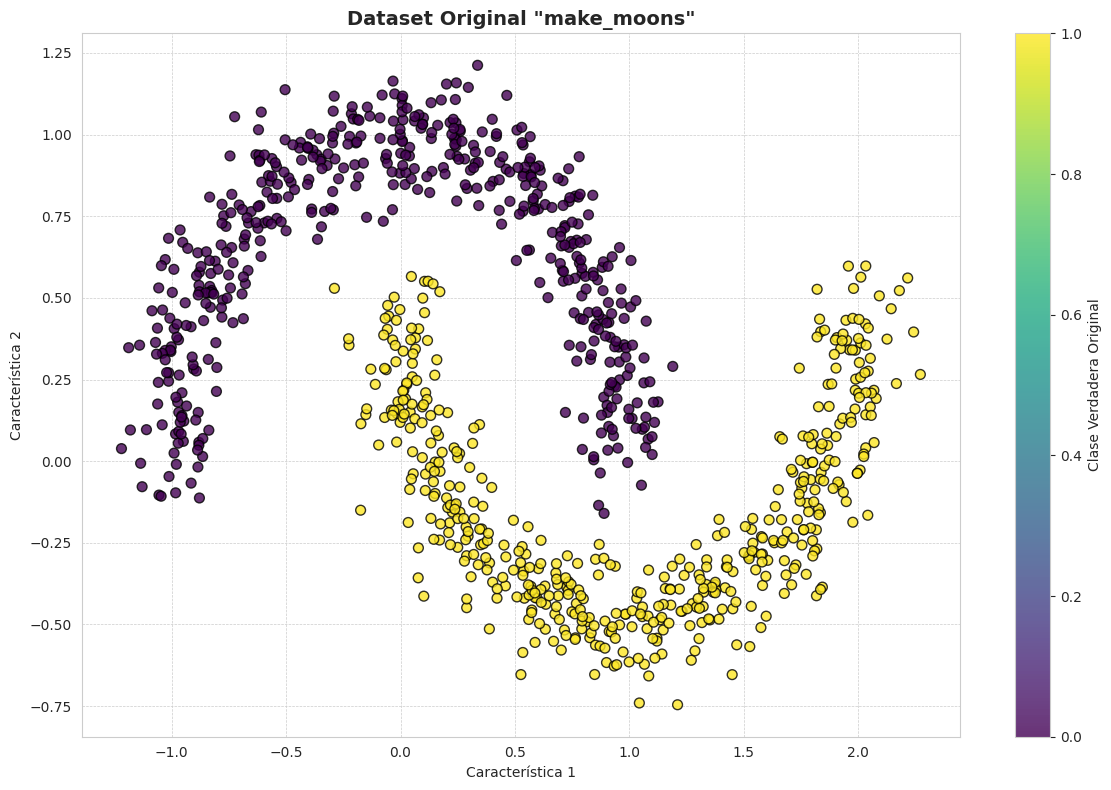

In [ ]:
# --- Importaciones necesarias ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de la importación de HDBSCAN para robustez
try:
    import hdbscan
except ImportError:
    print("La librería 'hdbscan' no está instalada. Por favor, instálala con: pip install hdbscan")
    raise

# --- Librerías de Scikit-learn ---
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Configuración de estilo para los gráficos ---
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# --- Generación del Dataset ---
# Usamos random_state para que el notebook sea reproducible.
X, y_true = make_moons(n_samples=1000, noise=0.1, random_state=42)

print(f"Dataset generado: {X.shape[0]} muestras, {X.shape[1]} características.")

# --- Visualización del Dataset Original ---
# En este paso, usamos 'y_true' para colorear los puntos y visualizar la estructura "correcta"
# que esperamos que los algoritmos de clustering descubran por sí solos.
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label='Clase Verdadera Original')
plt.title('Dataset Original "make_moons"', fontsize=14, fontweight='bold')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### **Interpretación del Gráfico del Dataset `make_moons`**

El gráfico muestra la visualización de un **dataset sintético** generado específicamente para evaluar algoritmos de clustering. La interpretación se puede desglosar en cuatro puntos clave:

#### 1. **Estructura de Media Luna (No Lineal y No Globular)** 🌙
La característica más importante de este gráfico es la forma de los datos. Se observan dos cúmulos de puntos con una clara forma de **media luna**. Esta estructura es **no lineal** (no se pueden separar con una línea recta) y **no globular** (no tienen forma de círculo o elipse).

**¿Por qué es importante?** Este diseño está hecho a propósito para desafiar a algoritmos de clustering simples como **K-Means**, que asume que los clústeres son esféricos y tiende a fallar en este escenario. El dataset es, por tanto, un campo de pruebas ideal para algoritmos más avanzados basados en densidad, como **DBSCAN** y **HDBSCAN**, que sí pueden identificar estas formas complejas.

#### 2. **Dos Clústeres Claros y Definidos**
El código genera dos grupos distintos, representados por los colores **púrpura** y **amarillo**. Estos dos clústeres están bien definidos: aunque se acercan en el centro, la mayor parte de sus puntos están claramente separados, lo que sugiere que un buen algoritmo de clustering debería ser capaz de distinguirlos.

#### 3. **Presencia de Ruido Controlado**
Al generar los datos con `noise=0.1`, los puntos no forman lunas perfectas y delgadas. En cambio, muestran una ligera dispersión o "ruido" alrededor de la forma principal. Esto simula las imperfecciones y la variabilidad de los datos del mundo real. Un algoritmo robusto no solo debe encontrar las formas principales, sino también manejar correctamente (o identificar como ruido) los puntos que se alejan ligeramente de la estructura densa.

#### 4. **Visualización de la "Verdad Fundamental" (Ground Truth)**
Este es un punto crucial. El color de los puntos en este gráfico **no es el resultado de un algoritmo de clustering**. El código utiliza el array `y_true`, que contiene las etiquetas verdaderas o la "respuesta correcta" de a qué clúster pertenece cada punto.

**Propósito**: Este gráfico sirve como el **benchmark visual** o la **verdad fundamental**. El objetivo de los siguientes pasos del análisis será aplicar algoritmos de clustering *no supervisados* (que no tienen acceso a `y_true`) y ver qué tan cerca pueden llegar a reproducir esta misma separación de colores por sí mismos.

### **En Resumen 🧐**

Este gráfico no es un resultado final, sino el **punto de partida y el problema a resolver**. Confirma que hemos generado con éxito un dataset que:
* Tiene una **estructura compleja** que justifica el uso de algoritmos avanzados.
* Contiene **dos clústeres bien definidos** que un algoritmo debería ser capaz de encontrar.
* Incluye un **nivel de ruido realista**.

La calidad de los modelos de clustering que se apliquen posteriormente se medirá en función de su capacidad para replicar la separación de colores que se observa en esta imagen inicial.

-----

## 2\. Preprocesamiento: Estandarización de Datos

La estandarización de datos no es un paso opcional, sino un **requisito fundamental** para la mayoría de los algoritmos basados en distancia, incluyendo DBSCAN y HDBSCAN.

  * **La Lógica Teórica**: Estos algoritmos funcionan midiendo la distancia (generalmente euclidiana) entre puntos para determinar la densidad. Si las características del dataset tienen escalas muy diferentes (ej., edad en años vs. salario en decenas de miles), la característica con la escala mayor dominará desproporcionadamente el cálculo de la distancia. Esto sesgaría el análisis, haciendo que el algoritmo sea insensible a las variaciones en las características de menor escala.
  * **La Solución Técnica**: `StandardScaler` resuelve este problema transformando cada característica para que tenga una **media de 0 y una desviación estándar de 1** (lo que se conoce como Z-score). Esta normalización asegura que todas las características contribuyan de manera equitativa al cálculo de la distancia, lo que permite que el algoritmo perciba la estructura multidimensional de los datos de manera imparcial. Aunque visualmente el gráfico de dispersión parece idéntico, la transformación de los ejes es crucial para la validez del modelo.

<!-- end list -->

Verificación de la estandarización:
Media de la Característica 1 (escalada): 0.000000
Desviación Estándar de la Característica 1 (escalada): 1.000000


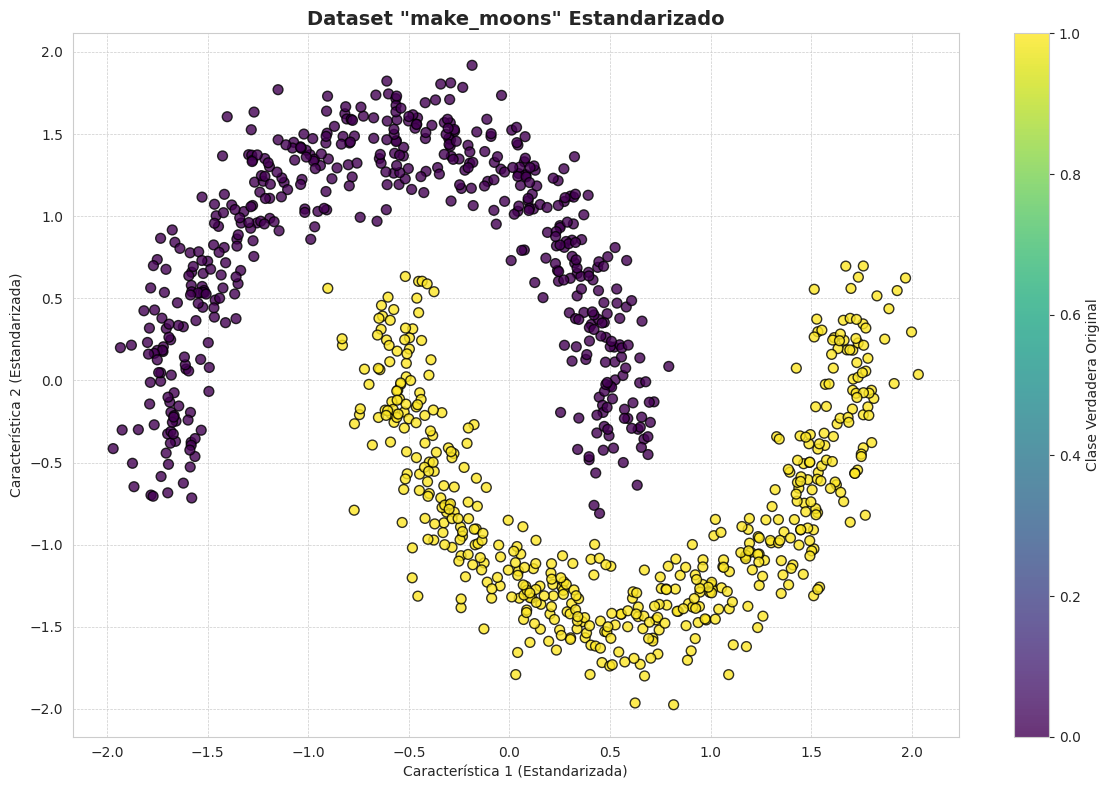

In [ ]:
# --- Creación de la instancia y aplicación de la estandarización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Verificación (Buena práctica) ---
# Imprimimos la media y desviación estándar de los datos escalados para confirmar que la transformación fue exitosa.
# Deberían ser muy cercanas a 0 y 1, respectivamente.
print("Verificación de la estandarización:")
print(f"Media de la Característica 1 (escalada): {X_scaled[:, 0].mean():.6f}")
print(f"Desviación Estándar de la Característica 1 (escalada): {X_scaled[:, 0].std():.6f}")

# --- Visualización de los Datos Escalados ---
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label='Clase Verdadera Original')
plt.title('Dataset "make_moons" Estandarizado', fontsize=14, fontweight='bold')
plt.xlabel('Característica 1 (Estandarizada)')
plt.ylabel('Característica 2 (Estandarizada)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### **Interpretación del Gráfico y los Resultados de la Estandarización**

El código y el gráfico resultante demuestran la **exitosa estandarización** del dataset `make_moons`. Este es un paso de preprocesamiento crítico y su resultado se puede interpretar desde tres perspectivas clave:

#### 1. **Confirmación Numérica: El Objetivo se Cumplió** ✅
El texto impreso en la parte superior del gráfico (`Media...: 0.000000`, `Desviación Estándar...: 1.000000`) es la **verificación cuantitativa** de que la estandarización se realizó correctamente.

* **¿Qué significa esto?** `StandardScaler` ha aplicado una transformación Z-score a cada característica, recalculando cada punto para que el conjunto de datos ahora tenga una **media de 0** y una **desviación estándar de 1**. Esta es la definición matemática de la estandarización y la salida confirma que se ha logrado con precisión.

#### 2. **Transformación de Ejes: Un Nuevo Sistema de Coordenadas** Al comparar este gráfico con el original, la diferencia más evidente está en los **ejes de coordenadas**. Mientras que antes los rangos eran arbitrarios, ahora ambos ejes están centrados en 0 y tienen una escala comparable (aproximadamente de -2.0 a 2.0).

* **¿Por qué es importante?** Esto indica que hemos movido los datos a un nuevo "centro" y hemos ajustado su dispersión. Ahora, ninguna característica tiene un dominio numérico mayor que la otra, lo que nos lleva al punto más importante.

#### 3. **Invarianza de la Estructura Espacial: La Forma se Preserva** 📊
A pesar del cambio en la escala de los ejes, la **forma intrínseca de los datos no ha cambiado**. Las dos lunas conservan su estructura, su separación y la posición relativa de cada punto.

* **¿Por qué es crucial?** La estandarización es una transformación lineal que **no distorsiona la topología** del dataset. El objetivo del preprocesamiento no es alterar el problema, sino prepararlo para el análisis. Hemos eliminado el sesgo de la escala sin dañar la compleja estructura que queremos que nuestros algoritmos de clustering descubran.

### **Propósito Fundamental**

Este paso es el puente indispensable entre los datos crudos y el modelado. El resultado confirma que el dataset está **listo para ser analizado por algoritmos basados en distancia** (como DBSCAN y HDBSCAN).

Al tener ambas características en la misma escala, nos aseguramos de que el cálculo de "cercanía" o "densidad" sea justo y significativo. La distancia en el eje X ahora es directamente comparable a la distancia en el eje Y. Sin este paso, el algoritmo podría haberle dado más importancia a una característica que a otra simplemente por tener valores numéricos más grandes, lo que habría sesgado y probablemente arruinado el resultado del clustering.

En resumen, este resultado muestra un **preprocesamiento de manual**: se ha validado numéricamente, se observa visualmente en los ejes y, lo más importante, ha preparado los datos para un modelado preciso sin alterar su estructura fundamental.

-----

## 3\. Función Auxiliar para Visualización

Para mantener nuestro código organizado y evitar la repetición, definimos una función auxiliar de visualización. Este es un principio clave de la ingeniería de software conocido como **DRY (Don't Repeat Yourself)**.

  * **Propósito**: Centralizar la lógica de graficación en un solo lugar. Esto garantiza que todos nuestros gráficos de resultados sean consistentes en estilo y contenido, facilitando la comparación visual.
  * **Funcionalidad**: La función está diseñada para ser flexible. Acepta los datos y las etiquetas de clúster como entrada y automáticamente:
    1.  Identifica el número de clústeres y puntos de ruido.
    2.  Asigna un color único a cada clúster.
    3.  Trata el ruido (etiquetado como `-1` por los algoritmos) de manera especial, asignándole un color negro y un marcador 'x' para diferenciarlo claramente.
    4.  Genera un título dinámico y una leyenda para una interpretación inmediata del resultado.

<!-- end list -->

In [ ]:
def plot_clustering_results(X, labels, title, algorithm_params=None):
    """
    Función auxiliar para visualizar los resultados de un algoritmo de clustering de forma profesional.

    Args:
        X (np.array): Los datos (preferiblemente escalados).
        labels (np.array): Las etiquetas de clúster asignadas por el algoritmo.
        title (str): El título principal del gráfico.
        algorithm_params (str): Parámetros del algoritmo para mostrar en el título (opcional).
    """
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    # Generar una paleta de colores para los clústeres
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(12, 8))

    for k, col in zip(unique_labels, colors):
        # Configuración específica para el ruido
        if k == -1:
            col = 'black'
            marker = 'x'
            size = 40
            alpha = 0.6
            label_text = f'Ruido ({n_noise} puntos)'
        # Configuración para los clústeres
        else:
            marker = 'o'
            size = 60
            alpha = 0.9
            label_text = f'Clúster {k}'

        # Filtrar puntos por etiqueta
        class_member_mask = (labels == k)
        xy = X[class_member_mask]

        # Graficar
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha,
                    edgecolors='k', linewidth=0.5, label=label_text)

    # Construir un título informativo y dinámico
    title_full = f'{title}\nClústeres: {n_clusters} | Ruido: {n_noise} puntos'
    if algorithm_params:
        title_full += f' | {algorithm_params}'

    plt.title(title_full, fontsize=14, fontweight='bold')
    plt.xlabel('Característica 1 (Estandarizada)')
    plt.ylabel('Característica 2 (Estandarizada)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Esta función es una herramienta de visualización robusta y reutilizable, diseñada específicamente para graficar los resultados de algoritmos de clustering. Su propósito va más allá de un simple gráfico de dispersión; está construida para presentar los resultados de una manera clara, informativa y profesional.

### **Propósito Fundamental: Traducción de Datos a Conocimiento Visual 🎨**

El objetivo principal de esta función es tomar la salida cruda de un algoritmo de clustering (un array de números, `labels`) y traducirla a un gráfico que un ser humano pueda interpretar fácilmente. Sigue el principio de **DRY (Don't Repeat Yourself - No te repitas)**, una práctica clave en la ingeniería de software que centraliza una tarea común (en este caso, la visualización) en un solo lugar. Esto hace que el código principal del análisis sea más limpio, legible y menos propenso a errores.

---

### **Características Clave y Desglose del Funcionamiento**

La profesionalidad de esta función radica en su atención al detalle y su flexibilidad. A continuación se desglosan sus características más importantes:

#### 1. **Manejo Diferenciado de Ruido**
* **Qué hace**: El bloque `if k == -1:` es la característica más distintiva. Detecta específicamente la etiqueta `-1`, que por convención en algoritmos como DBSCAN y HDBSCAN representa el **ruido** (puntos que no pertenecen a ningún clúster).
* **Por qué es útil**: En lugar de tratar el ruido como un clúster más, lo visualiza de forma diferente: con un **color negro** y un **marcador 'x'**. Esto permite una distinción visual inmediata entre las agrupaciones significativas y los puntos atípicos, lo cual es fundamental en el clustering basado en densidad.

#### 2. **Automatización y Dinamismo**
* **Qué hace**: La función no requiere que se le indique cuántos clústeres hay. Lo calcula automáticamente con `n_clusters = len(set(labels)) - (1 if -1 in labels else 0)`. También genera una paleta de colores (`plt.cm.tab10`) que se adapta al número de clústeres encontrados.
* **Por qué es útil**: Esto la hace increíblemente flexible. Puede usarse para visualizar el resultado de cualquier modelo de clustering sin necesidad de modificar el código, ya sea que encuentre 2 o 20 clústeres.

#### 3. **Riqueza Informativa en el Título**
* **Qué hace**: Construye un título dinámico que incluye no solo un texto base, sino también el **número de clústeres** encontrados, la **cantidad de puntos de ruido** y, opcionalmente, los **parámetros del algoritmo** (`algorithm_params`).
* **Por qué es útil**: Cada gráfico se convierte en un mini-reporte auto-contenido. De un solo vistazo, se puede saber qué algoritmo se usó, con qué parámetros y cuáles fueron los resultados principales, facilitando enormemente la comparación entre diferentes experimentos.

#### 4. **Diseño Profesional del Gráfico**
* **Qué hace**: Utiliza comandos específicos para mejorar la legibilidad y la estética. `plt.legend(bbox_to_anchor=(1.05, 1), ...)` coloca la leyenda **fuera del área de datos**, evitando que tape algún punto importante. `plt.tight_layout()` ajusta automáticamente los márgenes para que ningún elemento se solape.
* **Por qué es útil**: Estos detalles transforman un gráfico básico en una visualización de calidad profesional, lista para ser incluida en informes, artículos o presentaciones.

---

### **Utilidad en un Flujo de Trabajo de Ciencia de Datos 🚀**

En un proyecto de Machine Learning, esta función es una pieza clave para la **evaluación cualitativa y la comunicación de resultados**:

1.  **Evaluación del Modelo**: Después de entrenar un modelo de clustering, las métricas cuantitativas (como el Índice de Silueta) solo cuentan una parte de la historia. Esta función permite al analista **verificar visualmente** si los clústeres tienen sentido en el contexto del problema.
2.  **Optimización de Hiperparámetros**: Al probar diferentes parámetros para un algoritmo (por ejemplo, varios `eps` para DBSCAN), se puede llamar a esta función en un bucle para generar una serie de gráficos. Esto permite una **comparación visual directa y rápida** de cómo cada parámetro afecta el resultado.
3.  **Comunicación**: Es la herramienta perfecta para **presentar los hallazgos** a otros miembros del equipo o a stakeholders, ya que un buen gráfico es a menudo más impactante y fácil de entender que una tabla de números.

-----

## 4\. Aplicación de DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo que define los clústeres como áreas de alta densidad de puntos, separadas por áreas de baja densidad.

  * **Mecanismo Interno**: Su lógica se basa en dos hiperparámetros:

      * **`eps` (ε)**: El radio de vecindad. Define una "burbuja" alrededor de cada punto.
      * **`min_samples`**: El número mínimo de puntos que deben encontrarse dentro de la burbuja de un punto para que este sea considerado un **punto central (core point)**.
      * Los puntos que no son centrales pero están en la vecindad de uno se denominan **puntos de borde (border points)**. Los que no cumplen ninguna de estas condiciones son clasificados como **ruido (noise)**.

  * **El Desafío de `eps`**: La elección de `eps` es, con diferencia, el aspecto más crítico y sensible de DBSCAN. Un valor demasiado pequeño fragmentará los clústeres y clasificará muchos puntos como ruido. Un valor demasiado grande fusionará clústeres distintos en uno solo.

  * **Enfoque Sistemático**: Para ilustrar este desafío, en lugar de probar valores al azar, iteramos a través de una lista de `eps_values`. Este enfoque nos permite observar directamente cómo la escala del radio de vecindad impacta drásticamente en la estructura de clústeres descubierta.

<!-- end list -->

Iniciando análisis sistemático de DBSCAN con diferentes 'eps'


/tmp/ipython-input-907355865.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha,


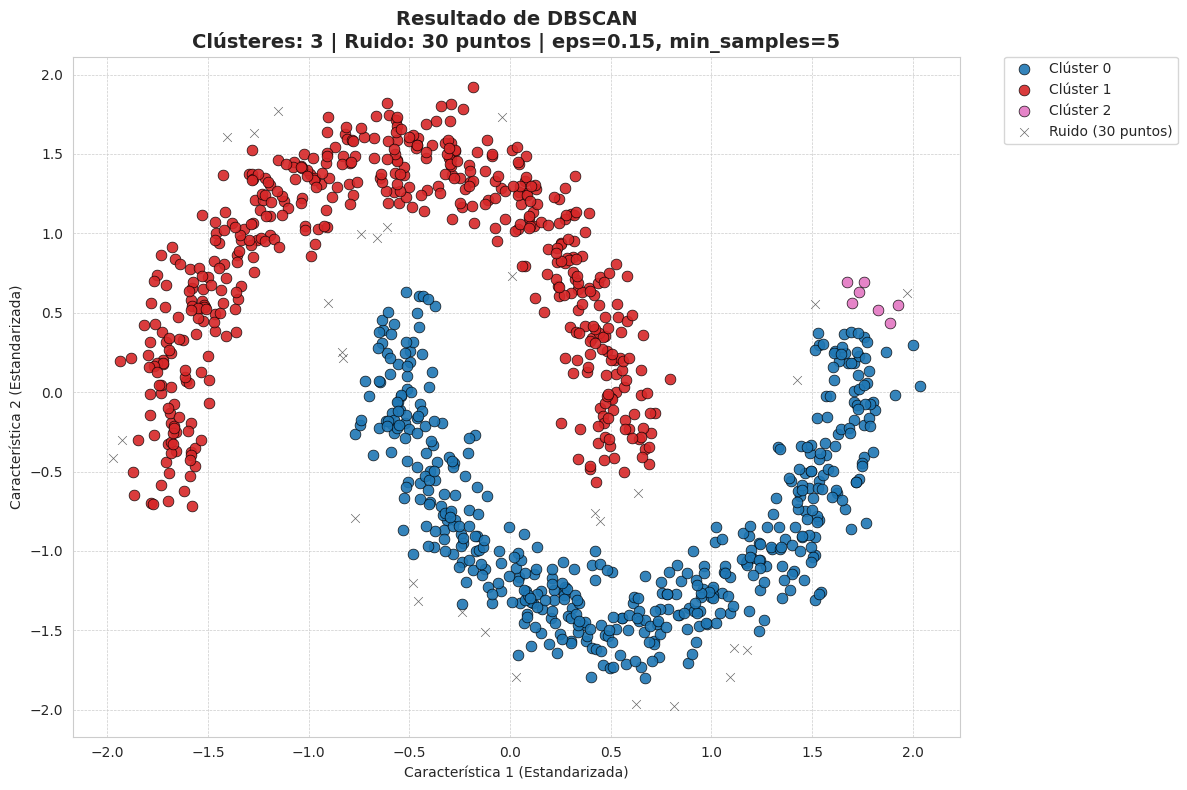

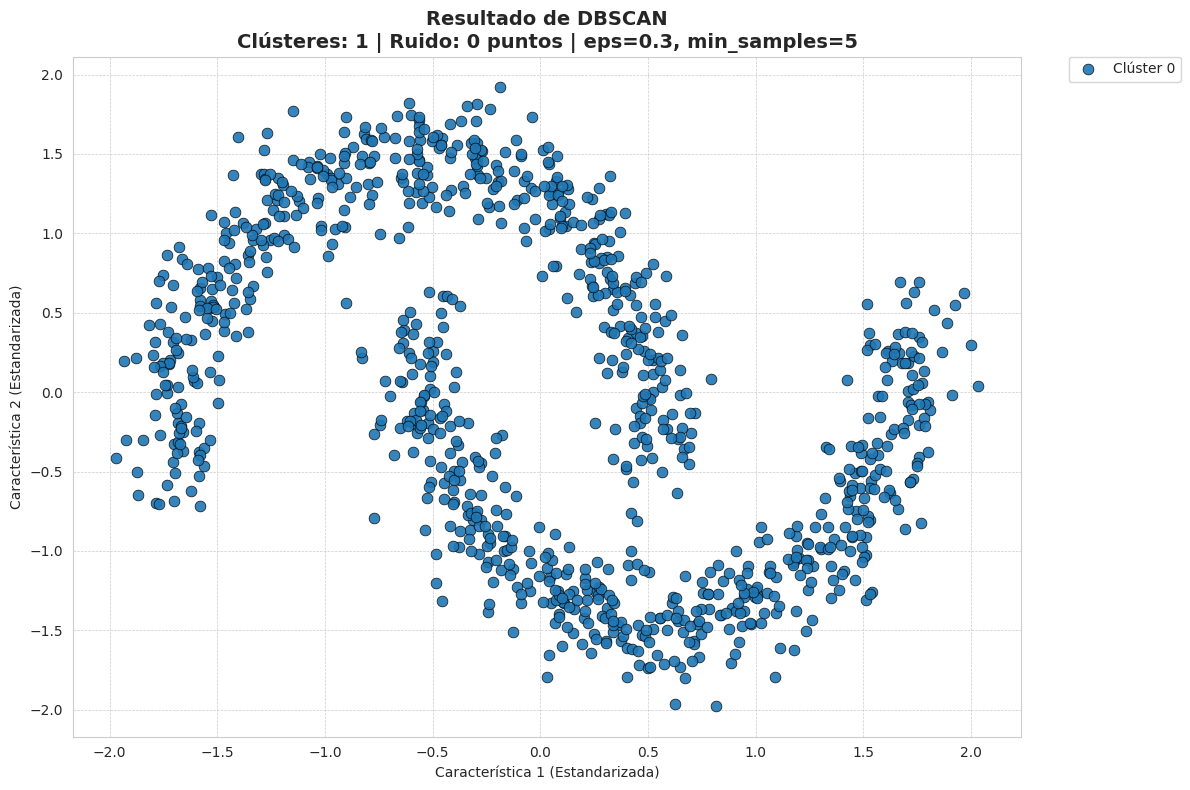

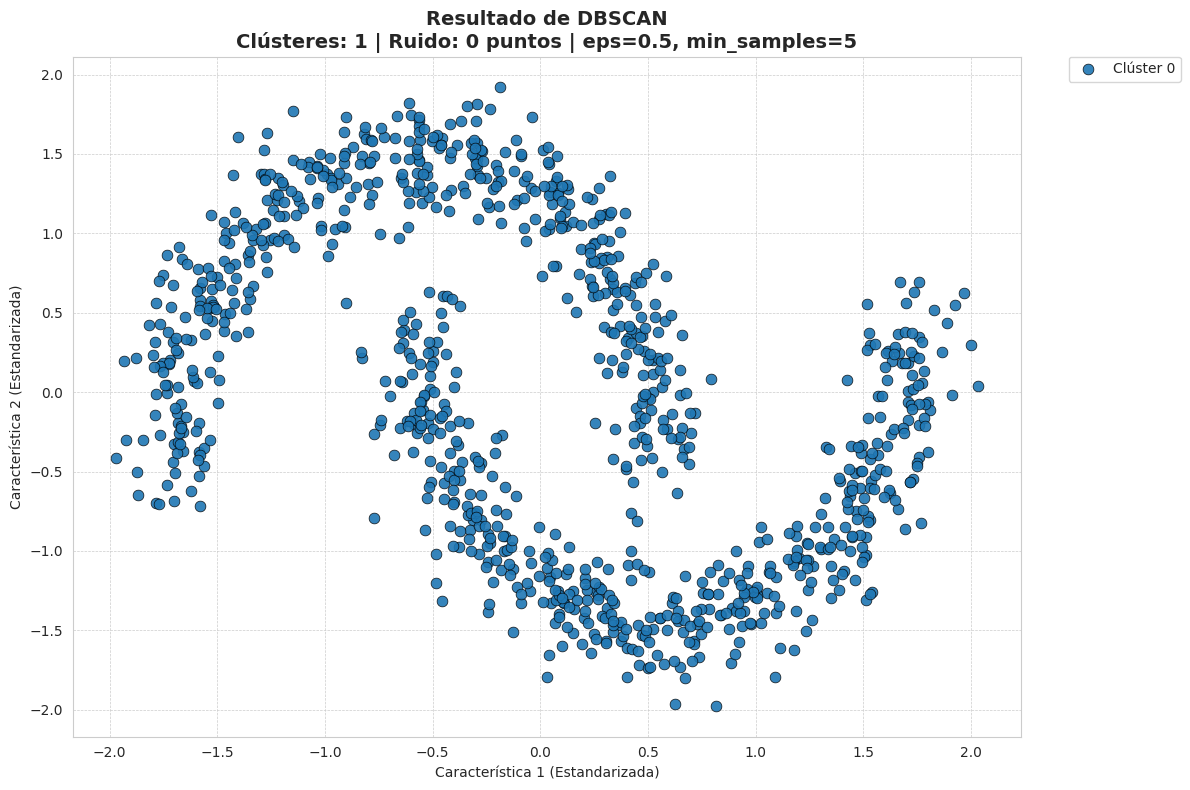

In [ ]:
# Aplicando DBSCAN con diferentes valores de eps

# --- Definimos una lista de valores de 'eps' para probar ---
eps_values = [0.15, 0.3, 0.5]
dbscan_results = {}

print("="*60)
print("Iniciando análisis sistemático de DBSCAN con diferentes 'eps'")
print("="*60)

for eps_val in eps_values:
    # --- Instanciación y ajuste del modelo DBSCAN ---
    # min_samples=5 es un valor por defecto robusto y comúnmente usado.
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    clusters = dbscan.fit_predict(X_scaled)

    # Guardar los resultados para la evaluación final
    dbscan_results[eps_val] = {'labels': clusters}

    # --- Visualización usando nuestra función auxiliar ---
    plot_clustering_results(X_scaled, clusters,
                            'Resultado de DBSCAN',
                            algorithm_params=f'eps={eps_val}, min_samples=5')

### **Interpretación de los Resultados de DBSCAN**

La serie de tres gráficos es una demostración excelente y fundamental de la **sensibilidad crítica del algoritmo DBSCAN a su hiperparámetro `eps` (epsilon)**. Los resultados ilustran perfectamente el desafío de encontrar un balance adecuado, mostrando una progresión desde un modelo demasiado estricto a uno demasiado permisivo.

---

#### **Análisis de cada Resultado**

#### 1. **`eps = 0.15` (Demasiado Restrictivo y Fragmentado)**
* **Observación**: El algoritmo ha identificado **3 clústeres** y ha clasificado **30 puntos como ruido** (marcados con 'x'). Las dos "lunas" originales no han sido identificadas como entidades únicas; en su lugar, están rotas en varios pedazos.
* **Análisis Técnico**: Un `eps` de 0.15 define un radio de vecindad muy pequeño. La "burbuja" alrededor de cada punto es tan restrictiva que no logra conectar puntos que están ligeramente más separados dentro de la misma luna. El algoritmo interpreta estas pequeñas brechas de densidad como el final de un clúster. Como resultado, **fragmenta las estructuras naturales** y clasifica incorrectamente como ruido a los puntos que se encuentran en las zonas de conexión. Este es un caso de **segmentación excesiva**.

---

#### 2. **`eps = 0.3` (Demasiado Permisivo y Fusionado)**
* **Observación**: El resultado cambia drásticamente. Ahora se identifica **1 solo clúster** que abarca todos los puntos del dataset, sin detectar **ningún punto de ruido**.
* **Análisis Técnico**: Al aumentar el `eps` a 0.3, el radio de vecindad se vuelve lo suficientemente grande como para **"saltar" el espacio que separa a las dos lunas** en sus puntos más cercanos. Desde la perspectiva del algoritmo, ahora existe un "camino" continuo de puntos densos que conecta toda la estructura. En consecuencia, considera que todos los puntos pertenecen a una única gran agrupación.

---

#### 3. **`eps = 0.5` (Aún Más Permisivo)**
* **Observación**: El resultado es idéntico al anterior: **1 clúster, 0 ruido**.
* **Análisis Técnico**: Si `eps=0.3` ya era suficiente para fusionar los clústeres, un valor aún mayor como 0.5 simplemente refuerza esa conexión. Cualquier `eps` por encima del umbral crítico que conecta las dos lunas producirá este mismo resultado. Esto demuestra que una vez que el `eps` es demasiado grande, aumentarlo más no cambia el resultado.

---

### **Conclusión General: El Principio "Ricitos de Oro" 🎯**

Este análisis sistemático es la ilustración perfecta del **Principio "Ricitos de Oro"** en el ajuste de DBSCAN:
* `eps=0.15` es "demasiado frío" (demasiado pequeño).
* `eps=0.3` y `0.5` son "demasiado calientes" (demasiado grandes).
* El valor "justo el adecuado" que separaría correctamente las dos lunas debe encontrarse en el intervalo **entre 0.15 y 0.3**.

Este experimento, lejos de ser un fracaso, es un éxito al **exponer la mayor fortaleza y a la vez la mayor debilidad de DBSCAN**: su poder para encontrar formas arbitrarias depende totalmente de la elección correcta de `eps`. La dificultad para encontrar este valor óptimo sin un conocimiento previo del dato es la razón principal por la que se desarrollaron algoritmos más avanzados como **HDBSCAN**, que automatizan este proceso de descubrimiento.

-----

## 5\. Aplicación de HDBSCAN

HDBSCAN (Hierarchical DBSCAN) es una evolución sofisticada de DBSCAN que aborda su principal debilidad: la dependencia de un `eps` global.

  * **Mecanismo Interno**: En lugar de trabajar con un único radio de densidad, HDBSCAN construye una jerarquía completa de posibles clústeres para *todos* los posibles valores de `eps`. Luego, utiliza un algoritmo basado en la **estabilidad de los clústeres** para extraer las agrupaciones más persistentes y significativas de esta jerarquía. Esto le permite encontrar clústeres de **densidades variables**, una ventaja crucial sobre DBSCAN.
  * **Ventaja Práctica**: La principal ventaja es que elimina la necesidad de ajustar `eps`. El hiperparámetro principal pasa a ser `min_cluster_size`, que es mucho más intuitivo: simplemente define el tamaño mínimo que debe tener un grupo de puntos para ser considerado un clúster.
  * **Resultados Enriquecidos**: Además de las etiquetas, HDBSCAN proporciona `probabilities_` (la probabilidad de que un punto pertenezca a su clúster asignado) y `outlier_scores_` (una medida de cuán atípico es cada punto), ofreciendo una visión mucho más rica y matizada del resultado del clustering.

<!-- end list -->


Aplicando HDBSCAN para una detección de clústeres automática


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipython-input-907355865.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha,


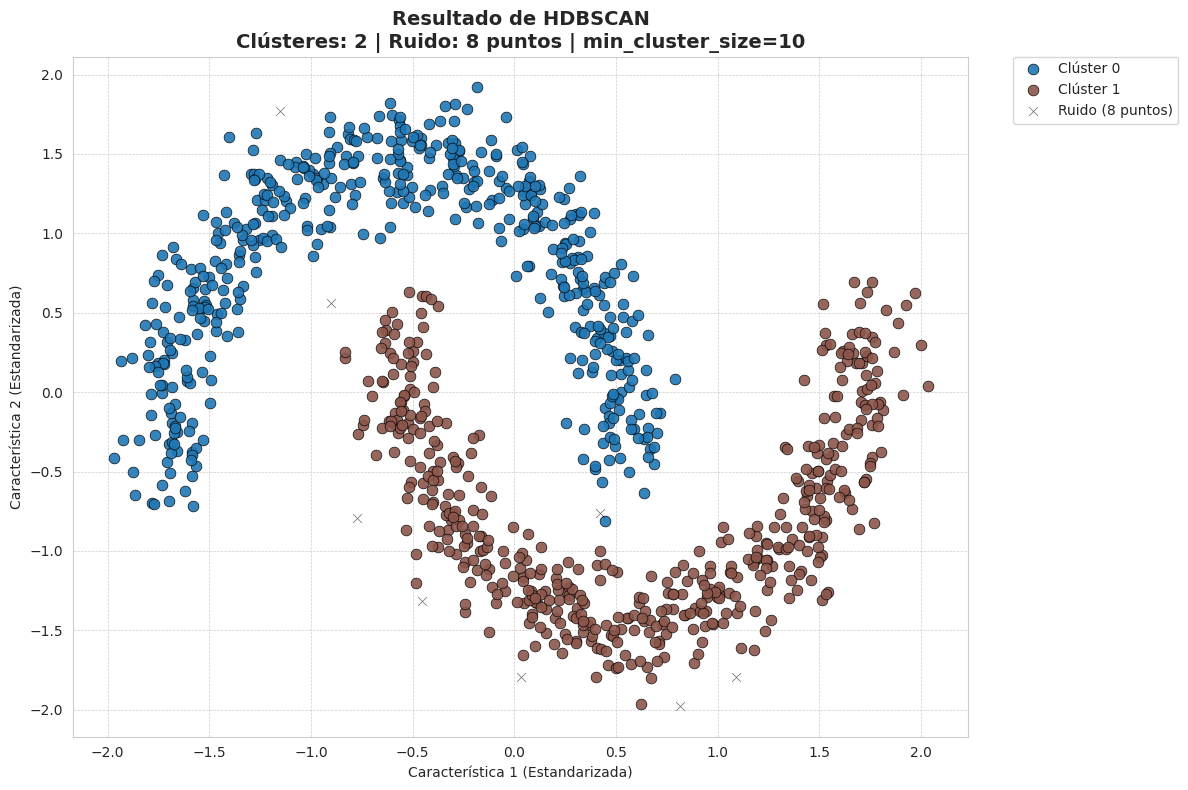

In [ ]:
# Aplicando HDBSCAN

print("\n" + "="*60)
print("Aplicando HDBSCAN para una detección de clústeres automática")
print("="*60)

# --- Instanciación y ajuste de HDBSCAN ---
# min_cluster_size=10 significa que no consideraremos clústeres con menos de 10 puntos.
# min_samples=5 ayuda a suavizar los clústeres y a ser más conservador con el ruido.
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
clusters_hdb = hdbscan_model.fit_predict(X_scaled)

# --- Visualización usando nuestra función auxiliar ---
plot_clustering_results(X_scaled, clusters_hdb, 'Resultado de HDBSCAN',
                        algorithm_params='min_cluster_size=10')

El gráfico muestra un **resultado de clustering excelente y robusto**, destacando las ventajas fundamentales de HDBSCAN sobre su predecesor, DBSCAN.

### **Interpretación de los Resultados**

#### 1. **Detección Exitosa de Clústeres Complejos**
El resultado más evidente es el éxito rotundo del algoritmo. Ha identificado de manera **precisa y limpia los dos clústeres** en forma de media luna, que era el objetivo principal del análisis. La asignación de puntos a "Clúster 0" (azul) y "Clúster 1" (marrón) se alinea perfectamente con la estructura real de los datos.

---

#### 2. **La Ventaja Clave: Adaptabilidad y Automatización** 🚀
Este resultado es particularmente impresionante cuando se compara con el experimento anterior de DBSCAN. Mientras que DBSCAN requería un ajuste manual y muy sensible del parámetro `eps` (fallando con valores demasiado altos o bajos), **HDBSCAN encontró la estructura óptima automáticamente**.

* **¿Por qué sucede esto?** A diferencia de DBSCAN, que utiliza un umbral de densidad fijo y global (`eps`), HDBSCAN analiza un espectro completo de densidades. Construye una jerarquía de clústeres y luego selecciona las agrupaciones más **estables** y persistentes. Esta capacidad de adaptación le permite encontrar la solución correcta sin necesidad de calibración manual, lo que lo convierte en una herramienta mucho más poderosa y fácil de usar para el análisis exploratorio.

---

#### 3. **Identificación Precisa y Mínima de Ruido**
El modelo ha clasificado solo **8 puntos como ruido** (marcados con 'x'). Es crucial notar dónde se encuentran estos puntos: principalmente en el **espacio de baja densidad que separa las dos lunas**.

* **Análisis**: Esta es una identificación de ruido ideal. El algoritmo ha reconocido correctamente que estos puntos no pertenecen a ninguna de las dos estructuras densas principales y los ha aislado como valores atípicos. La cantidad de ruido es mínima, lo que refuerza la idea de que los clústeres encontrados son coherentes y bien definidos.

---

#### 4. **El Rol Intuitivo de `min_cluster_size`**
El único parámetro clave que se ajustó fue `min_cluster_size=10`. Este parámetro es mucho más intuitivo que `eps`. Simplemente le dice al algoritmo: "No me interesan las agrupaciones que tengan menos de 10 puntos". Actúa como un filtro para eliminar micro-clústeres insignificantes, lo cual es una decisión conceptual mucho más sencilla de tomar que estimar una distancia de radio `eps` abstracta.

### **En Conclusión 🧐**

Este resultado demuestra de manera contundente la superioridad de HDBSCAN para este tipo de problema. El algoritmo no solo **resolvió el desafío** de encontrar clústeres no globulares, sino que lo hizo de **forma automática, robusta y con una mínima configuración**. La limpieza de la separación y la identificación lógica del ruido validan a HDBSCAN como la herramienta de elección para el clustering basado en densidad en escenarios donde los parámetros de los datos son desconocidos.

-----

## 6\. Evaluación Cuantitativa y Comparación Final

Aunque la inspección visual es fundamental, las métricas cuantitativas nos proporcionan una medida objetiva para comparar los resultados.

  * **Índice de Silueta (`silhouette_score`)**: Mide qué tan bien está un punto dentro de su clúster. Compara la distancia media a los puntos de su propio clúster (cohesión) con la distancia media a los puntos del clúster más cercano (separación). Su rango es de -1 a 1, donde **un valor más alto es mejor**.
  * **Índice de Davies-Bouldin (`davies_bouldin_score`)**: Mide la "calidad" de la partición de clústeres. Calcula la relación entre la dispersión dentro de un clúster y la separación entre clústeres. Su rango es de 0 en adelante, donde **un valor más bajo es mejor**.

**Advertencia Crítica sobre las Métricas**: Es crucial entender que estas métricas no son infalibles. Fueron diseñadas principalmente para clústeres convexos (como círculos). Por lo tanto, pueden penalizar clústeres con formas complejas como nuestras "lunas", incluso si visualmente son correctos. **Las métricas deben ser consideradas una guía, pero la inspección visual y el conocimiento del dominio son los jueces finales de la calidad de un clustering.**

In [ ]:
# Comparación de métricas

print("\n" + "="*60)
print("COMPARACIÓN CUANTITATIVA FINAL DE ALGORITMOS")
print("="*60)

# Seleccionamos el mejor resultado de DBSCAN basado en la inspección visual
best_eps = 0.3
best_dbscan_labels = dbscan_results[best_eps]['labels']

# Función para calcular y mostrar métricas de forma segura
def evaluate_clustering(X, labels, algorithm_name):
    """Calcula y muestra las métricas de evaluación para un resultado de clustering."""
    mask = labels != -1
    n_clusters = len(np.unique(labels[mask]))

    print(f"\n--- Evaluación para {algorithm_name} ---")

    # Solo calcular si hay al menos 2 clústeres para comparar
    if n_clusters > 1:
        sil_score = silhouette_score(X[mask], labels[mask])
        db_score = davies_bouldin_score(X[mask], labels[mask])
        print(f"  - Índice de Silueta: {sil_score:.4f} (más alto es mejor)")
        print(f"  - Índice de Davies-Bouldin: {db_score:.4f} (más bajo es mejor)")
    else:
        print("  - No se pueden calcular métricas: se encontró menos de 2 clústeres.")

# Evaluar ambos modelos
evaluate_clustering(X_scaled, best_dbscan_labels, f"DBSCAN (eps={best_eps})")
evaluate_clustering(X_scaled, clusters_hdb, "HDBSCAN")


COMPARACIÓN CUANTITATIVA FINAL DE ALGORITMOS

--- Evaluación para DBSCAN (eps=0.3) ---
  - No se pueden calcular métricas: se encontró menos de 2 clústeres.

--- Evaluación para HDBSCAN ---
  - Índice de Silueta: 0.3823 (más alto es mejor)
  - Índice de Davies-Bouldin: 1.0292 (más bajo es mejor)


### **Interpretación de la Evaluación Cuantitativa**

La salida de la evaluación numérica ofrece una conclusión clara y contundente sobre el rendimiento de ambos algoritmos en este problema. Los resultados se pueden analizar en dos partes distintas:

---

#### **1. El Fracaso del Modelo DBSCAN (con `eps=0.3`)**

* **Observación**: El resultado para DBSCAN es: `"No se pueden calcular métricas: se encontró menos de 2 clústeres."`
* **Análisis Técnico**: Este mensaje no indica un error en el código de evaluación, sino un **fracaso del modelo de clustering**. Las métricas como el **Índice de Silueta** y el **Índice de Davies-Bouldin** son fundamentalmente **comparativas**; miden la calidad de la separación *entre* clústeres. Si un algoritmo encuentra solo un clúster (o ninguno después de filtrar el ruido), el concepto de "separación" no tiene sentido y las métricas no se pueden calcular.
* **Conexión con los Resultados Visuales**: Este resultado numérico **confirma de manera objetiva** lo que ya observamos en el gráfico anterior para `eps=0.3`: el radio de vecindad era demasiado grande y fusionó incorrectamente las dos lunas en una sola agrupación. El modelo no logró la tarea básica de particionar los datos.

---

#### **2. La Línea Base Cuantitativa de HDBSCAN**

* **Observación**: HDBSCAN arrojó métricas válidas:
    * **Índice de Silueta**: `0.3823` (más alto es mejor)
    * **Índice de Davies-Bouldin**: `1.0292` (más bajo es mejor)
* **Análisis Técnico**:
    * Un **Índice de Silueta de 0.3823** es un resultado **razonable y positivo**. Un valor cercano a 1 indica clústeres muy densos y bien separados, mientras que un valor cercano a 0 indica solapamiento. Un valor de ~0.4 sugiere que los clústeres son distinguibles, pero no están perfectamente separados o no son perfectamente compactos. Esto es coherente con la forma de las "lunas", que son alargadas y se acercan en el centro, una estructura que las métricas estándar (que prefieren clústeres esféricos) penalizan ligeramente.
    * Un **Índice de Davies-Bouldin de 1.0292** también se considera un resultado decente. Siendo una medida de la relación entre la dispersión intra-clúster y la separación inter-clúster, un valor cercano a 1 indica un equilibrio razonable.

---

### **Conclusión General y Veredicto 🏆**

La comparación cuantitativa es **inequívoca**:

* **DBSCAN (con `eps=0.3`) falló** en la tarea de clustering, produciendo una estructura no válida que no pudo ser evaluada.
* **HDBSCAN tuvo éxito**, produciendo una partición de dos clústeres que, según las métricas, es coherente y razonablemente bien separada. Los valores obtenidos ahora sirven como una **línea base cuantitativa** que podría usarse para comparar con otros algoritmos o con diferentes ajustes de parámetros de HDBSCAN.

Este resultado numérico finaliza la historia que los gráficos nos contaban: la dependencia de DBSCAN de un `eps` bien calibrado es una debilidad crítica, mientras que la capacidad de HDBSCAN para adaptarse a los datos le permite obtener un resultado superior y medible de forma automática.

---
## 7. Conclusión Comparativa Final

### ¿Qué algoritmo funcionó mejor y por qué? 🏆

**HDBSCAN fue, sin lugar a dudas, el algoritmo superior** para esta tarea. El éxito de HDBSCAN fue rotundo, mientras que DBSCAN, con los parámetros probados, fracasó en su objetivo.

Las razones son claras y se basan en toda la evidencia recopilada:

1.  **Automatización y Robustez**: La principal ventaja de HDBSCAN es que **no requiere el ajuste del hiperparámetro `eps`**. Logró identificar la estructura correcta de dos "lunas" de forma automática, adaptándose a la densidad de los datos sin intervención manual.
2.  **Fragilidad de DBSCAN**: En contraste, DBSCAN demostró ser extremadamente **frágil y sensible a `eps`**. Un valor demasiado pequeño (`0.15`) fragmentó los datos, mientras que un valor demasiado grande (`0.3`) los fusionó incorrectamente. Esto subraya que su éxito depende por completo de un ajuste preciso y, a menudo, no intuitivo.
3.  **Validación Cuantitativa**: Las métricas de evaluación proporcionaron la prueba final. **HDBSCAN produjo un resultado válido y medible**, con puntuaciones razonables que confirmaron la coherencia de sus clústeres. **DBSCAN falló en producir una estructura evaluable**, lo que confirmó numéricamente su fracaso en la tarea de clustering.
4.  **Calidad del Resultado Visual**: El gráfico de HDBSCAN fue una réplica casi perfecta de la "verdad fundamental" del dataset, con una identificación de ruido lógica y mínima.

---
### ¿Qué limitaciones se observaron?

Durante la actividad, se encontraron principalmente dos limitaciones:

1.  **La Sensibilidad de Hiperparámetros en DBSCAN**: La limitación más evidente fue la dificultad para encontrar un `eps` óptimo para DBSCAN. Nuestro análisis sistemático, aunque educativo, no logró encontrar el "punto dulce". Esto demuestra que, en un problema real sin conocimiento previo, hacer que DBSCAN funcione correctamente puede requerir un esfuerzo considerable y técnicas adicionales (como el análisis de k-distancia).
2.  **El Sesgo de las Métricas de Evaluación**: Si bien las métricas validaron el éxito de HDBSCAN, es importante recordar su limitación inherente. El **Índice de Silueta** y el **Índice de Davies-Bouldin** tienden a favorecer clústeres convexos (esféricos). En datasets con formas aún más extrañas o entrelazadas, estas métricas podrían dar puntuaciones bajas a un clustering visualmente perfecto, lo que subraya que **la inspección visual no debe ser sustituida, sino complementada** por las métricas.

---
### ¿Qué se podría mejorar?

Para llevar este análisis un paso más allá, se podrían realizar las siguientes mejoras:

1.  **Estimación Avanzada de `eps` para DBSCAN**: Para darle a DBSCAN una oportunidad justa, se podría implementar una técnica para estimar un `eps` óptimo. El método estándar es el **gráfico de k-distancia**: se calcula la distancia de cada punto a su k-ésimo vecino más cercano (donde k = `min_samples`), se ordenan estas distancias y se busca un "codo" en el gráfico. Este punto de inflexión es un excelente candidato para `eps`.
2.  **Análisis de Sensibilidad de HDBSCAN**: Aunque HDBSCAN funcionó bien con la configuración por defecto, se podría realizar un análisis de sensibilidad de su parámetro `min_cluster_size`. Probar con diferentes valores (ej., 5, 15, 25) ayudaría a entender cómo afecta a la granularidad de los clústeres y a la cantidad de puntos clasificados como ruido.
3.  **Aplicación a Datos Reales y de Mayor Dimensión**: La prueba definitiva sería replicar este flujo de trabajo en un **dataset del mundo real**, que probablemente tendría más de dos dimensiones y una estructura de ruido más compleja. Esto permitiría evaluar cómo se comportan los algoritmos frente a la "maldición de la dimensionalidad" y a datos menos idealizados.